# PART 1: Bootstrapping Swap Curves

### Import packages

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import brentq

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

 # <a id = "top">Contents</a>

# [1. OIS Discount Factor Calculation](#p1)
# [2. LIBOR Discount Factor Calculation](#p2)
# [3. Results for 1&2](#p3)
# [4. Forward Swap Rates Calculation](#p4)

#  <a id = "p1"> 1.<font color = "green">OIS Discount Factor Calculation [(back to contents)](#top)

In [3]:
OIS_data = pd.read_excel("IR Data.xlsx",sheet_name="OIS")
OIS_data = OIS_data.drop(["Unnamed: 3","Unnamed: 4","Unnamed: 5"],axis=1)
OIS_data 

,Tenor,Product,Rate
0,6m,OIS,0.00250
1,1y,OIS,0.00300
2,2y,OIS,0.00325
3,3y,OIS,0.00335
4,4y,OIS,0.00350
5,5y,OIS,0.00360
6,7y,OIS,0.00400
7,10y,OIS,0.00450
8,15y,OIS,0.00500
9,20y,OIS,0.00525


Calculate $D_{o}\left( 0,0.5\right)$ and $D_{o}\left( 0,1\right)$ at first.

In [4]:
def DF_to_OR(d,i):
    return ((1/d)**(1/360*i)-1)*360
def OR_to_DF(f,i):
    return 1/(1+f/360)**(360*i)

In [5]:
OIS_data["Tenor"] = [1/2,1,2,3,4,5,7,10,15,20,30]
Tenor = pd.DataFrame({"Tenor": np.arange(0,31,1),
                     "Value": np.arange(0,31,1)})
OIS_data_new = pd.merge(OIS_data, Tenor, on="Tenor",how="outer")
OIS_data_new = OIS_data_new.sort_values(by="Tenor").reset_index(drop=True)
OIS_data_new = OIS_data_new.drop(["Value","Product"], axis=1)
OIS_data_new = OIS_data_new.drop(OIS_data_new.index[0]).reset_index(drop=True)

f0 = ((OIS_data_new.loc[0,"Tenor"]*OIS_data_new.loc[0,"Rate"]+1)**(1/180)-1)*360
OIS_data_new.loc[0,"Discount Factor"] = OR_to_DF(f0,OIS_data_new.loc[0,"Tenor"])

f1 = (((OIS_data_new.loc[1,"Tenor"]*OIS_data_new.loc[1,"Rate"]+1)/(1+f0/360)**180)**(1/180)-1)*360
OIS_data_new.loc[1,"Discount Factor"] = 1/((1+f0/360)**180*(1+f1/360)**180)


/var/folders/w2/14sx_j5n1c1875xr78ggrzmr0000gn/T/ipykernel_12171/4255947847.py:4: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  OIS_data_new = pd.merge(OIS_data, Tenor, on="Tenor",how="outer")


In [6]:
OIS_data_new

,Tenor,Rate,Discount Factor
0,0.5,0.00250,0.998752
1,1.0,0.00300,0.997009
2,2.0,0.00325,NaN
3,3.0,0.00335,NaN
4,4.0,0.00350,NaN
5,5.0,0.00360,NaN
6,6.0,NaN,NaN
7,7.0,0.00400,NaN
8,8.0,NaN,NaN
9,9.0,NaN,NaN


At $tenor=t$
* For fixed leg: 
$$
PV_{fix}=OISR_{t}\times \sum^{t}_{i=1} \left( D_{o}\left( 0,i\right)  \right)  
$$
* For float leg: we can syplify the formula into 
$$
PV_{flt}=1-D_{o}\left( 0,t\right), (t\geq 2)
$$
* In this way, we can the calculate OIS discount factors with different ternors through solving equations.

In [7]:
def calc_DF_M1(pv_flt, sumation, i, DF):
    pv_flt = 1 - DF
    sumation = sumation + DF
    pv_fix = OIS_data_new["Rate"][i] * sumation
    return pv_flt, pv_fix, sumation

In [8]:
def find_value(i, DF_end, sumation):
    DF_begin = OIS_data_new.loc[i,"Discount Factor"]
    m = i+1
    while (pd.isna(OIS_data_new["Rate"][m])==True):
        m=m+1
        if (pd.isna(OIS_data_new["Rate"][m])==False):
            sumation = sumation + (DF_begin + DF_end)*(m-i+1)/2
            pv_flt = 1-DF_end
            pv_fix = OIS_data_new["Rate"][m] * sumation
            
        else:
            continue
    return pv_flt, pv_fix, sumation, m

In [9]:
def find_value2(i, DF_end, sumation):
    DF_begin = value
    #print(DF_begin)
    sumation = sumation + (DF_begin + DF_end)*(i-key+1)/2
    pv_flt = 1-DF_end
    pv_fix = OIS_data_new["Rate"][i] * sumation

    return pv_flt, pv_fix, sumation, i

In [10]:
pv_flt = OIS_data_new.loc[1,"Discount Factor"]*((1+f0/360)**180*(1+f1/360)**180-1)
sumation = OIS_data_new.loc[1,"Discount Factor"]
for i in range(2,len(OIS_data_new)):
    if (pd.isna(OIS_data_new["Rate"][i])==False) :
        if (pd.isna(OIS_data_new["Discount Factor"][i]) == True) & (pd.isna(OIS_data_new["Discount Factor"][i-1]) == False):
            OIS_data_new.loc[i,"Discount Factor"] = brentq(lambda x: calc_DF_M1(pv_flt, sumation, i, x)[0]-calc_DF_M1(pv_flt, sumation, i, x)[1],
                                -10000, 10000)
            pv_fix = calc_DF_M1(pv_flt, sumation, i, OIS_data_new.loc[i,"Discount Factor"])[1]
            pv_flt = calc_DF_M1(pv_flt, sumation, i, OIS_data_new.loc[i,"Discount Factor"])[0]
            
            if pd.isna(OIS_data_new["Rate"][i+1])==False:
                sumation = calc_DF_M1(pv_flt, sumation, i, OIS_data_new.loc[i,"Discount Factor"])[2]
            if pd.isna(OIS_data_new["Rate"][i+1])==True:
                value = brentq(lambda x: find_value(i, x, sumation)[0]-find_value(i, x, sumation)[1],
                                -10000, 10000)
                key = find_value(i, value, sumation)[3]
                OIS_data_new.loc[key,"Discount Factor"] = value
                sumation = find_value(i, value, sumation)[2]-value
        if (pd.isna(OIS_data_new["Discount Factor"][i]) == False):
            continue
        else:
            value1 = brentq(lambda x: find_value2(i, x, sumation)[0]-find_value2(i, x, sumation)[1],
                                -10000, 10000)
            sumation = find_value2(i, value1, sumation)[2]-value1
            key = find_value2(i, value1, sumation)[3]
            OIS_data_new.loc[key,"Discount Factor"] = value1
            value=value1
            
    else:
        continue

In [11]:
OIS_data_new

,Tenor,Rate,Discount Factor
0,0.5,0.00250,0.998752
1,1.0,0.00300,0.997009
2,2.0,0.00325,0.993531
3,3.0,0.00335,0.990015
4,4.0,0.00350,0.986117
5,5.0,0.00360,0.982184
6,6.0,NaN,NaN
7,7.0,0.00400,0.972406
8,8.0,NaN,NaN
9,9.0,NaN,NaN


Apply linear interpolation on discount factors we obtained above.

In [12]:
OIS_data_final = OIS_data_new.interpolate(method='linear')
OIS_data_final

,Tenor,Rate,Discount Factor
0,0.5,0.002500,0.998752
1,1.0,0.003000,0.997009
2,2.0,0.003250,0.993531
3,3.0,0.003350,0.990015
4,4.0,0.003500,0.986117
5,5.0,0.003600,0.982184
6,6.0,0.003800,0.977295
7,7.0,0.004000,0.972406
8,8.0,0.004167,0.966929
9,9.0,0.004333,0.961453


#  <a id = "p2"> 2.<font color = "green">LIBOR Discount Factor Calculation [(back to contents)](#top)

In [13]:
IRS_data = pd.read_excel("IR Data.xlsx",sheet_name="IRS")
IRS_data = IRS_data.drop(["Unnamed: 3","Unnamed: 4","Unnamed: 5"],axis=1)
IRS_data 

,Tenor,Product,Rate
0,6m,LIBOR,0.0250
1,1y,IRS,0.0280
2,2y,IRS,0.0300
3,3y,IRS,0.0315
4,4y,IRS,0.0325
5,5y,IRS,0.0330
6,7y,IRS,0.0350
7,10y,IRS,0.0370
8,15y,IRS,0.0400
9,20y,IRS,0.0450


Likewise, we calculate $\widetilde{D} \left( 0,0.5\right)  $ and $\widetilde{D} \left( 0,1\right)  $ at first.

In [14]:
IRS_data["Tenor"] = [1/2,1,2,3,4,5,7,10,15,20,30]
Tenor1 = pd.DataFrame({"Tenor": np.arange(0,30.5,0.5),
                     "Value": np.arange(0,30.5,0.5)})
IRS_data_new = pd.merge(IRS_data, Tenor1, on="Tenor",how="outer")
IRS_data_new = IRS_data_new.sort_values(by="Value")
IRS_data_new = IRS_data_new.drop(["Value", "Product"],axis = 1).reset_index(drop=True)
IRS_data_new = IRS_data_new.drop(0).reset_index(drop=True)
OIS_DF = pd.merge(Tenor1, OIS_data_final, how = "outer")
OIS_DF = OIS_DF["Discount Factor"].drop(0).reset_index(drop=True).interpolate(method='linear')
IRS_data_new = pd.concat([IRS_data_new, OIS_DF], axis = 1)
IRS_data_new["LIBOR_DF"]=np.nan
IRS_data_new.columns = ["Tenor", "Rate", "ON_DF", "LIBOR_DF"]
IRS_data_new.loc[0,"LIBOR_DF"]=1/(1+1/2*IRS_data_new["Rate"][0])
L_6m_1y = (IRS_data_new["Rate"][1]*(IRS_data_new["ON_DF"][0]+IRS_data_new["ON_DF"][1])-IRS_data_new["Rate"][0]*IRS_data_new["ON_DF"][0])/IRS_data_new["ON_DF"][1]
IRS_data_new.loc[1,"LIBOR_DF"] = IRS_data_new.loc[0,"LIBOR_DF"]/(L_6m_1y/2+1)
IRS_data_new

,Tenor,Rate,ON_DF,LIBOR_DF
0,0.5,0.0250,0.998752,0.987654
1,1.0,0.0280,0.997009,0.972577
2,1.5,NaN,0.995270,NaN
3,2.0,0.0300,0.993531,NaN
4,2.5,NaN,0.991773,NaN
5,3.0,0.0315,0.990015,NaN
6,3.5,NaN,0.988066,NaN
7,4.0,0.0325,0.986117,NaN
8,4.5,NaN,0.984150,NaN
9,5.0,0.0330,0.982184,NaN


Because the swap market is collateralized in cash and overnight interest is paid on collateral posted. At tenor equal to t $(t>1)$
* For fixed leg: 
$$
PV_{fix}=IRSR_{t}\times \sum^{t}_{i=1} \left( D_{o}\left( 0,i\right)  \right)\times 0.5  
$$ 
* For float leg: \
$$
PV_{flt} = [D_{o}\left( 0,0.5y\right)  \times \widetilde{D} \left( 0,0.5y\right)  +D_{o}\left( 0,1y\right)  \times \widetilde{D} \left( 0,1y\right)  +...+D_{o}\left( 0,t\right)  \times \widetilde{D} \left( 0,t\right)  ]\times 0.5
$$\
$$
=[D_{o}\left( 0,0.5y\right)  \times \frac{1}{0.5} \times \frac{\widetilde{D} \left( 0,0\right)  -\widetilde{D} \left( 0,0.5y\right)  }{\widetilde{D} \left( 0,0.5y\right)  } +D_{o}\left( 0,1y\right)  \times \frac{1}{0.5} \times \frac{\widetilde{D} \left( 0,0.5y\right)  -\widetilde{D} \left( 0,1y\right)  }{\widetilde{D} \left( 0,1y\right)  } +...+D_{o}\left( 0,t\right)  \times \frac{1}{0.5} \times \frac{\widetilde{D} \left( 0,(t-0.5)y\right)  -\widetilde{D} \left( 0,ty\right)  }{\widetilde{D} \left( 0,ty\right)  } ]\times 0.5
$$\
$$
=[D_{o}\left( 0,0.5y\right)  \times \frac{\widetilde{D} \left( 0,0\right)  }{\widetilde{D} \left( 0,0.5y\right)  } +D_{o}\left( 0,1y\right)  \times \frac{\widetilde{D} \left( 0,0.5y\right)  }{\widetilde{D} \left( 0,1y\right)  } +...+D_{o}\left( 0,t\right)  \times \frac{\widetilde{D} \left( 0,(t-0.5)y\right)  }{\widetilde{D} \left( 0,ty\right)  } ]-\sum^{t}_{i=0.5} D_{o}\left( 0,i\right)  
$$
* In this way, we can the calculate LIBOR discount factors with different ternors through solving equations.

In [15]:
def LIBOR_DF(i, m, DF_end, pv_flt):
    IRS_data_new.loc[i,"LIBOR_DF"] = DF_end
    df_new = pd.DataFrame({"LIBOR_DF": IRS_data_new.loc[m:i,"LIBOR_DF"].interpolate(method='linear'),
                          "ON_DF": IRS_data_new.loc[m:i,"ON_DF"]}).reset_index(drop = True)
    pv_fix = 0.5*sum(IRS_data_new.loc[0:i,"ON_DF"])*IRS_data_new["Rate"][i]
    pv_flt = calc_flt_leg(pv_flt, df_new)
    return pv_flt, pv_fix

In [16]:
def calc_flt_leg(pv_flt, df):
    for j in range(0,len(df)-1):
        pv_flt = pv_flt + df["ON_DF"][j+1] * (df["LIBOR_DF"][j]/df["LIBOR_DF"][j+1])
    
    return pv_flt

In [17]:
pv_flt = IRS_data_new["ON_DF"][0]*(1/IRS_data_new["LIBOR_DF"][0])+IRS_data_new["ON_DF"][1]*(IRS_data_new["LIBOR_DF"][0]/IRS_data_new["LIBOR_DF"][1])
count = 0
m = 1
for i in range(2,len(IRS_data_new)):
    if (pd.isna(IRS_data_new["Rate"][i])==False):
        
        IRS_data_new.loc[i,"LIBOR_DF"] = brentq(lambda x: LIBOR_DF(i,m,x,pv_flt)[0]-sum(IRS_data_new.loc[0:i,"ON_DF"])-LIBOR_DF(i,m,x,pv_flt)[1], 1e-12, 2)
        pv_flt = LIBOR_DF(i,m,IRS_data_new.loc[i,"LIBOR_DF"],pv_flt)[0]
        m = i
    else:
        continue

In [18]:
IRS_data_new

,Tenor,Rate,ON_DF,LIBOR_DF
0,0.5,0.0250,0.998752,0.987654
1,1.0,0.0280,0.997009,0.972577
2,1.5,NaN,0.995270,NaN
3,2.0,0.0300,0.993531,0.942179
4,2.5,NaN,0.991773,NaN
5,3.0,0.0315,0.990015,0.910482
6,3.5,NaN,0.988066,NaN
7,4.0,0.0325,0.986117,0.878981
8,4.5,NaN,0.984150,NaN
9,5.0,0.0330,0.982184,0.848989


Apply linear interpolation on discount factors we obtained above.

In [19]:
IRS_data_final = IRS_data_new.interpolate(method='linear')
IRS_data_final

,Tenor,Rate,ON_DF,LIBOR_DF
0,0.5,0.025000,0.998752,0.987654
1,1.0,0.028000,0.997009,0.972577
2,1.5,0.029000,0.995270,0.957378
3,2.0,0.030000,0.993531,0.942179
4,2.5,0.030750,0.991773,0.926330
5,3.0,0.031500,0.990015,0.910482
6,3.5,0.032000,0.988066,0.894731
7,4.0,0.032500,0.986117,0.878981
8,4.5,0.032750,0.984150,0.863985
9,5.0,0.033000,0.982184,0.848989


#  <a id = "p3"> 3.<font color = "green">Results for 1&2 [(back to contents)](#top)

Text(0, 0.5, 'Discount Factor')

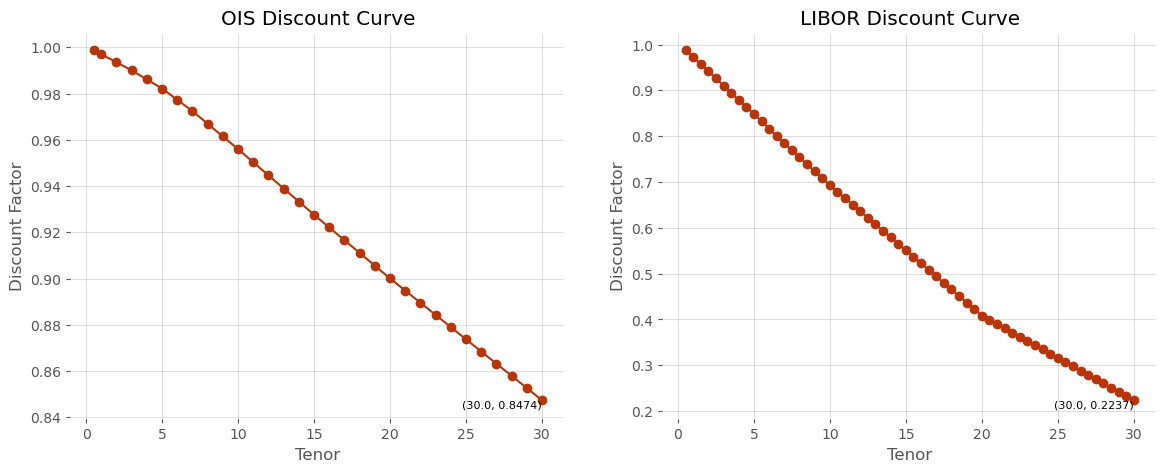

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
tenor_30 = OIS_data_final.loc[30,"Tenor"]
DF_30 = OIS_data_final.loc[30,"Discount Factor"]
plt.plot(OIS_data_final["Tenor"],OIS_data_final["Discount Factor"],marker='o', linestyle='-', c = "#B73508")
plt.text(tenor_30, DF_30, f'({tenor_30:.1f}, {DF_30:.4f})', ha='right', va='top', fontsize=8, color='black')
plt.title('OIS Discount Curve')
plt.xlabel('Tenor')
plt.ylabel('Discount Factor')
plt.subplot(122)
tenor_60 = IRS_data_final.loc[59,"Tenor"]
DF_60 = IRS_data_final.loc[59,"LIBOR_DF"]
plt.plot(IRS_data_final["Tenor"],IRS_data_final["LIBOR_DF"],marker='o', linestyle='-', c = "#B73508")
plt.text(tenor_60, DF_60, f'({tenor_60:.1f}, {DF_60:.4f})', ha='right', va='top', fontsize=8, color='black')
plt.title('LIBOR Discount Curve')
plt.xlabel('Tenor')
plt.ylabel('Discount Factor')


#  <a id = "p4"> 4.<font color = "green">Forward Swap Rates Calculation [(back to contents)](#top)

$$
\text{Forward Libor Rate} = \frac{\widetilde{D}(0, T_n) - \widetilde{D}(0, T_{n+0.5})}{\widetilde{D}(0, T_{n+0.5})}
$$

In [21]:
IRS_data_final['LIBOR_Rate'] = (IRS_data_final['LIBOR_DF'].shift(1) - IRS_data_final['LIBOR_DF']) / IRS_data_final['LIBOR_DF'] / 0.5
IRS_data_final['LIBOR_Rate'][0] = IRS_data_final['Rate'][0]

To calculate forward swap rate:
* For float leg:
$$
PV_{\text{flt}} = 0.5 \cdot \sum^n_{i=0.5} D_o(0, T_i) \cdot \text{LIBOR}(0, T_i)
$$
* For fix leg:
$$
PV_{\text{fix}} = 0.5 \cdot K \cdot \sum^n_{i=0.5} D_o(0, T_i) 
$$

$$
\text{Forward Swap Rate} = K = \frac{PV_{\text{flt}}}{PV01}
$$

In [22]:
def Forward_Swap_Rate(start, duration):
    start_value = IRS_data_final.loc[IRS_data_final['Tenor'] == start, 'Tenor'].values[0]
    end = start + duration
    end_value = IRS_data_final.loc[IRS_data_final['Tenor'] == end, 'Tenor'].values[0]
    indices = np.arange(start_value + 0.5, end_value + 0.5 , 0.5)
    PV_flt_sum = 0  # Initialize sum for floating leg
    PV_fix_sum = 0  # Initialize sum for fixed leg

    for i in indices:
        i = list(IRS_data_final.index[IRS_data_final["Tenor"]==i])[0]
        PV_flt_sum += 0.5 * IRS_data_final.loc[i, 'ON_DF'] * IRS_data_final.loc[i, 'LIBOR_Rate']
        PV_fix_sum += 0.5 * IRS_data_final.loc[i, 'ON_DF']

    # Calculate the forward swap rate
    forward_swap_rate = PV_flt_sum / PV_fix_sum

    return forward_swap_rate

In [23]:
df_Forward_Swap_Rate = pd.DataFrame([['1Y', '1Y', Forward_Swap_Rate(1,1)],
                                 ['1Y', '2Y', Forward_Swap_Rate(1,2)],
                                 ['1Y', '3Y', Forward_Swap_Rate(1,3)],
                                 ['1Y', '5Y', Forward_Swap_Rate(1,5)],
                                 ['1Y', '10Y', Forward_Swap_Rate(1,10)],
                                 ['5Y', '1Y', Forward_Swap_Rate(5,1)],
                                 ['5Y', '2Y', Forward_Swap_Rate(5,2)],
                                 ['5Y', '3Y', Forward_Swap_Rate(5,3)],
                                 ['5Y', '5Y', Forward_Swap_Rate(5,5)],
                                 ['5Y', '10Y', Forward_Swap_Rate(5,10)],
                                 ['10Y', '1Y', Forward_Swap_Rate(10,1)],
                                 ['10Y', '2Y', Forward_Swap_Rate(10,2)],
                                 ['10Y', '3Y', Forward_Swap_Rate(10,3)],
                                 ['10Y', '5Y', Forward_Swap_Rate(10,5)],
                                 ['10Y', '10Y', Forward_Swap_Rate(10,10)]],
                                 columns = ['Expiry', 'Tenor', 'Forward Swap Rate'])

In [24]:
df_Forward_Swap_Rate

,Expiry,Tenor,Forward Swap Rate
0,1Y,1Y,0.032007
1,1Y,2Y,0.033259
2,1Y,3Y,0.034011
3,1Y,5Y,0.035255
4,1Y,10Y,0.038428
5,5Y,1Y,0.039274
6,5Y,2Y,0.040075
7,5Y,3Y,0.040072
8,5Y,5Y,0.041093
9,5Y,10Y,0.043634
